In [ ]:
# Gerekli kütüphaneleri yükleme
!pip install jsonlines
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://github.com/ahmetaa/zemberek-nlp/releases/download/v0.17.1/zemberek-full.jar -O zemberek-full.jar
!pip install py4j
!pip install jpype1
!pip install zemberek-python


import jsonlines
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from zemberek import TurkishMorphology
from py4j.java_gateway import JavaGateway
import jpype
import jpype.imports
from jpype.types import JString
import jsonlines

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 MB 4.7 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141211 sha256=3605e95878883eeefea7521eba87d76225d09d40e6f1dd9f8848ec91b491072a
  Stored in directory: /root/.cache/pip/wheels/21/10/be/9a70640a3a60ed4a7e1a45e49bb9f58b04692d5d7b517bd39e
Successfully built antlr4-python3-runtime


In [ ]:
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')


Mounted at /content/drive


Mounted at /content/drive


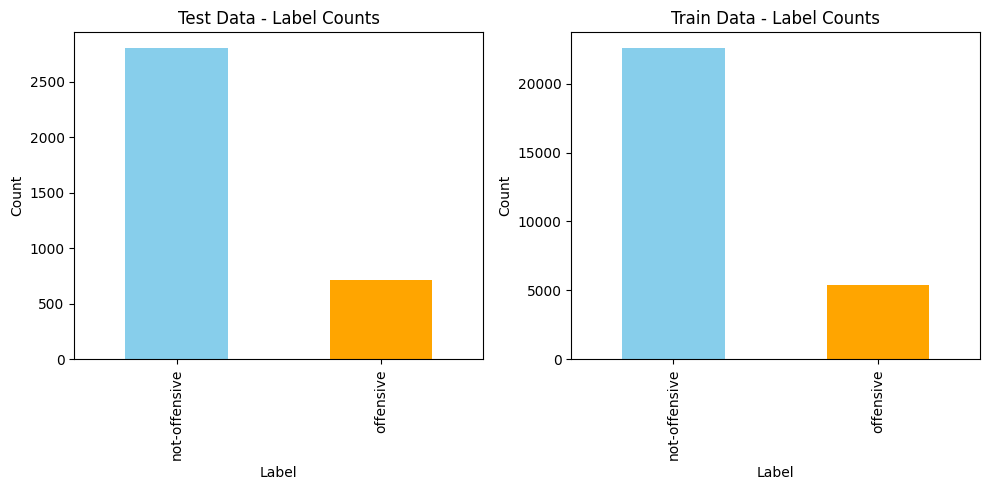

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Google Drive'ı bağlayalım
drive.mount('/content/drive')

# Dosya yollarını belirleyelim
train_file_path = '/content/drive/MyDrive/zemcleaned_data_test.csv'
test_file_path = '/content/drive/MyDrive/zemcleaned_data.csv'

# CSV dosyalarını yükleyelim
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

# Train ve test verilerindeki etiketlerin sayısını alalım
train_label_counts = train_df['label'].value_counts()
test_label_counts = test_df['label'].value_counts()

# Grafik oluşturma
plt.figure(figsize=(10, 5))

# Train verisinin grafiği
plt.subplot(1, 2, 1)
train_label_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Test Data - Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')

# Test verisinin grafiği
plt.subplot(1, 2, 2)
test_label_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Train Data - Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')

# Grafiklerin gösterilmesi
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from zemberek import TurkishMorphology
from zemberek.tokenization import TurkishTokenizer
import re

# Zemberek'i başlat
morphology = TurkishMorphology.create_with_defaults()
tokenizer = TurkishTokenizer.DEFAULT

# Stopwords ve link temizliği
stop_words = {'https', 'ol', 'co', 'bir', 'var', 't', 've', 'bu', 'da', 'de',
             'için', 'olarak', 'ama', 'yani', 'çok'}

# Küfürlü kısaltmalar listesi
offensive_abbreviations = {'amk', 'aq'}

def remove_stopwords_links_and_hashes(input_text):
    input_text = re.sub(r'http\S+|www\S+', '', input_text)  # Linkleri çıkar
    input_text = re.sub(r'#\S+', '', input_text)           # '#' ile başlayan ifadeleri çıkar
    input_text = re.sub(r'@\S+', '', input_text)           # '@' ile başlayan ifadeleri çıkar
    input_text = ' '.join(word for word in input_text.split()
                         if len(word) > 1 and word not in stop_words)
    return input_text

# Küfürlü kısaltmaları ve kelimeleri metinden çıkarma (Metni özel işleme)
def keep_offensive_abbreviations(input_text):
    # Küfürlü kısaltmaları metinden çıkarma (bunu geçici olarak yapıyoruz)
    for abbrev in offensive_abbreviations:
        input_text = input_text.replace(abbrev, f" {abbrev} ")  # Kısaltmaları belirgin hale getir
    return input_text

# Metinleri ön işleme
def preprocess_text(input_text):
    input_text = input_text.lower()  # Küçük harfe çevir
    input_text = keep_offensive_abbreviations(input_text)  # Küfürlü kısaltmaları metne dahil et

    tokens = tokenizer.tokenize(input_text)  # Tokenize et
    stems = []
    for token in tokens:
        # Kök çözümleme, yalnızca normal kelimeler için yapılacak
        if token.normalized not in offensive_abbreviations:  # Kısaltmaları işlem dışı bırak
            analyses = morphology.analyze(token.normalized)  # Kökleri bul
            if analyses.analysis_results:
                best_analysis = analyses.analysis_results[0]
                stems.append(best_analysis.get_stem())  # En iyi analizi al
        else:
            # Kısaltma metne olduğu gibi eklenir
            stems.append(token.normalized)

    # Kısaltmaları metne geri ekle
    processed_text = ' '.join(stems)

    return processed_text

# Metinleri temizle ve işleme al
df = pd.read_json("/content/drive/My Drive/train.jsonlines", lines=True)
df['Processed_Text'] = df['text'].apply(preprocess_text)
df['Processed_Text'] = df['Processed_Text'].apply(remove_stopwords_links_and_hashes)

# Etiketleri sayısal değerlere dönüştürme
df['Offensive_Label'] = df['label'].map({'not-offensive': 0, 'offensive': 1})

# Sonuçları kontrol et
print(df[['text', 'Processed_Text', 'label', 'Offensive_Label']].head())

# Temizlenmiş veriyi Google Drive'a kaydet
output_file_path = '/content/drive/My Drive/zemcleaned_data.csv'  # Kaydetmek istediğiniz tam yol
df.to_csv(output_file_path, index=False)

print(f"Temizlenmiş veri CSV dosyasına kaydedildi: {output_file_path}")


INFO:zemberek.morphology.turkish_morphology:TurkishMorphology instance initialized in 6.414513826370239


2025-04-12 20:52:34,038 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 6.414513826370239

                                                text  \
0  @USER en güzel uyuyan insan ödülü jeon jungkoo...   
1  @USER Mekanı cennet olsun, saygılar sayın avuk...   
2  Kızlar aranızda kas yığını beylere düşenler ol...   
3  Biraz ders çalışayım. Tembellik ve uyku düşman...   
4  @USER Trezeguet yerine El Sharawy daha iyi olm...   

                                  Processed_Text          label  \
0  en güzel uyu insan ödül jeon jungkook gid ...  not-offensive   
1  mekan cennet saygı sayın avukat iyi günle dil  not-offensive   
2    kız ara kas yığın bey düş gör yap allah aşk  not-offensive   
3            biraz ders çalış tembel uyku düşman  not-offensive   
4          trezeguet yerine el daha iyi olmaz mı  not-offensive   

   Offensive_Label  
0                0  
1                0  
2                0  
3                0  
4                

In [ ]:
# Gerekli kütüphaneleri yükleyin
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import numpy as np
import torch

# GPU kullanılabilir mi kontrol et
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU kullanılabilir. PyTorch modeli GPU'ya taşındı.")
else:
    device = torch.device("cpu")
    print("GPU kullanılmıyor. PyTorch modeli CPU'ya taşındı.")

# Google Drive'ı bağla (sadece Google Colab için)
drive.mount('/content/drive')

# Veri setini yükle
file_path = '/content/drive/My Drive/zemcleaned_data.csv'  # Dosyanızın tam yolunu belirtin
df = pd.read_csv(file_path)

# Etiketlerin Şifrelenmesi
label_encoder = LabelEncoder()
df['Offensive_Label'] = label_encoder.fit_transform(df['label'])

print("Şifrelenmiş Etiketler:")
print(df[['label', 'Offensive_Label']].drop_duplicates())

# BERTurk Tokenizer ve Modelini Yükleyin
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased")
model = AutoModel.from_pretrained("dbmdz/bert-base-turkish-cased")

# Metinleri Embedding'e çevirme fonksiyonu
def get_bert_embeddings(texts):
    embeddings = []
    for text in tqdm(texts, desc="Embedding İşlemi"):
        # Metnin string olup olmadığını ve boş olmadığını kontrol et
        if isinstance(text, str) and text:
            inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = model(**inputs)
            # [CLS] token çıkışları (Cümle Embedding'i)
            embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())
        else:
            # String olmayan veya boş metinleri işle (örneğin, boş bir embedding ile değiştir)
            embeddings.append(np.zeros(model.config.hidden_size))
    return embeddings

# Temizlenmiş metinleri Embedding'e dönüştürme
texts = df['Processed_Text'].tolist()
embeddings = get_bert_embeddings(texts)

# Embedding'leri DataFrame'e ekleme
embedding_df = pd.DataFrame(embeddings)
embedding_df.columns = [f"embedding_{i}" for i in range(embedding_df.shape[1])]
df = pd.concat([df, embedding_df], axis=1)

# Sonuçları kaydetme
output_file = "berturk_embeddings.csv"
df.to_csv(output_file, index=False)
print(f"Embedding sonuçları {output_file} dosyasına kaydedildi.")

from google.colab import drive
drive.mount('/content/drive')
output_file = "/content/drive/My Drive/zemberturk_embeddings.csv"
df.to_csv(output_file, index=False)
print(f"Embedding sonuçları {output_file} dosyasına kaydedildi.")

GPU kullanılabilir. PyTorch modeli GPU'ya taşındı.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Şifrelenmiş Etiketler:
           label  Offensive_Label
0  not-offensive                0
8      offensive                1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Embedding İşlemi: 100%|██████████| 28000/28000 [42:46<00:00, 10.91it/s]


Embedding sonuçları berturk_embeddings.csv dosyasına kaydedildi.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Embedding sonuçları /content/drive/My Drive/zemberturk_embeddings.csv dosyasına kaydedildi.


In [ ]:
import pandas as pd
from zemberek import TurkishMorphology
from zemberek.tokenization import TurkishTokenizer
import re

# Zemberek'i başlat
morphology = TurkishMorphology.create_with_defaults()
tokenizer = TurkishTokenizer.DEFAULT

# Stopwords ve link temizliği
stop_words = {'https', 'ol', 'co', 'bir', 'var', 't', 've', 'bu', 'da', 'de',
             'için', 'olarak', 'ama', 'yani', 'çok'}

# Küfürlü kısaltmalar listesi
offensive_abbreviations = {'amk', 'aq'}

def remove_stopwords_links_and_hashes(input_text):
    input_text = re.sub(r'http\S+|www\S+', '', input_text)  # Linkleri çıkar
    input_text = re.sub(r'#\S+', '', input_text)           # '#' ile başlayan ifadeleri çıkar
    input_text = re.sub(r'@\S+', '', input_text)           # '@' ile başlayan ifadeleri çıkar
    input_text = ' '.join(word for word in input_text.split()
                         if len(word) > 1 and word not in stop_words)
    return input_text

# Küfürlü kısaltmaları ve kelimeleri metinden çıkarma (Metni özel işleme)
def keep_offensive_abbreviations(input_text):
    # Küfürlü kısaltmaları metinden çıkarma (bunu geçici olarak yapıyoruz)
    for abbrev in offensive_abbreviations:
        input_text = input_text.replace(abbrev, f" {abbrev} ")  # Kısaltmaları belirgin hale getir
    return input_text

# Metinleri ön işleme
def preprocess_text(input_text):
    input_text = input_text.lower()  # Küçük harfe çevir
    input_text = keep_offensive_abbreviations(input_text)  # Küfürlü kısaltmaları metne dahil et

    tokens = tokenizer.tokenize(input_text)  # Tokenize et
    stems = []
    for token in tokens:
        # Kök çözümleme, yalnızca normal kelimeler için yapılacak
        if token.normalized not in offensive_abbreviations:  # Kısaltmaları işlem dışı bırak
            analyses = morphology.analyze(token.normalized)  # Kökleri bul
            if analyses.analysis_results:
                best_analysis = analyses.analysis_results[0]
                stems.append(best_analysis.get_stem())  # En iyi analizi al
        else:
            # Kısaltma metne olduğu gibi eklenir
            stems.append(token.normalized)

    # Kısaltmaları metne geri ekle
    processed_text = ' '.join(stems)

    return processed_text

# Metinleri temizle ve işleme al
df = pd.read_json("/content/drive/My Drive/test.jsonlines", lines=True)
df['Processed_Text'] = df['text'].apply(preprocess_text)
df['Processed_Text'] = df['Processed_Text'].apply(remove_stopwords_links_and_hashes)

# Etiketleri sayısal değerlere dönüştürme
df['Offensive_Label'] = df['label'].map({'not-offensive': 0, 'offensive': 1})

# Sonuçları kontrol et
print(df[['text', 'Processed_Text', 'label', 'Offensive_Label']].head())

# Temizlenmiş veriyi Google Drive'a kaydet
output_file_path = '/content/drive/My Drive/zemcleaned_data_test.csv'  # Kaydetmek istediğiniz tam yol
df.to_csv(output_file_path, index=False)

print(f"Temizlenmiş veri CSV dosyasına kaydedildi: {output_file_path}")


INFO:zemberek.morphology.turkish_morphology:TurkishMorphology instance initialized in 6.223986625671387


2025-04-07 13:25:58,572 - zemberek.morphology.turkish_morphology - INFO
Msg: TurkishMorphology instance initialized in 6.223986625671387

                                                text  \
0    @USER Sayın başkanım bu şekilde devam inşallah👏   
1  Herkes gevşekliği kadar duyar kasıyor,hayat bö...   
2  Olgun ilişkisi olan arkadaş size en güzel hedi...   
3  @USER @USER Burada atıp tutacağına o kötü koşu...   
4   @USER İşte o onur dediğin sende yok sorun o işte   

                                 Processed_Text          label  \
0                      sayın başkan şekil devam  not-offensive   
1     herkes gevşek kadar duyar kas hayat böyle  not-offensive   
2      olgun ilişki arkadaş siz en güzel hediye  not-offensive   
3  bura at tutacağ kötü koşul kuruş se çalış yi      offensive   
4                          onur se yok sor işte      offensive   

   Offensive_Label  
0                0  
1                0  
2                0  
3                1  
4                1  
Te